# EEG Decoding Analysis

### Introduction
Welcome to the EEG Decoding Analysis tutorial. In this session, we will explore the process of decoding EEG data to differentiate between two types of visual stimuli: animate and inanimate objects. This tutorial will guide you through loading preprocessed EEG epochs, visualizing the data, creating appropriate labels for our two conditions, and implementing machine learning techniques to decode the EEG signals based on the type of stimulus.

We will begin by reviewing the preprocessing steps to ensure you understand how the data was prepared for analysis. Then, we will load the epoch data, create labels for the animate and inanimate categories, and employ decoding techniques to classify the EEG responses corresponding to these categories.

In the next section, we will delve into category decoding, using methods that allow us to assess how well we can predict whether a stimulus was animate or inanimate based on the EEG data. This will involve setting up a machine learning pipeline, performing cross-validated decoding, and analyzing the decoding performance over time.

Let's start by setting up our environment and loading the necessary Python libraries and EEG dataset.



In [2]:
# Enable inline plotting for Jupyter Notebooks
%matplotlib inline


# Import necessary libraries
import sys
from itertools import combinations
import numpy as np
import mne
from mne.decoding import SlidingEstimator, cross_val_multiscore
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold, StratifiedKFold
import matplotlib.pyplot as plt

sys.path.append('../')
from utils.plotting import display_stim

n_splits = 5
print("Libraries imported successfully.")

Libraries imported successfully.


## Load and Inspect Preprocessed Epochs

First, let's load the preprocessed epochs from an MNE-compatible file. This file contains epochs that have been already cleaned and are ready for analysis.

Before we dive into decoding, it's important to review the preprocessing steps that have been applied to the EEG data. These steps typically include:
1. Filtering to remove high-frequency noise and slow drifts.
2. Artifact removal, such as using Independent Component Analysis (ICA) to eliminate eye blinks and heartbeats.
3. Epoching the data around stimulus presentation times.
4. Applying baseline correction to normalize the signal.

These preprocessing steps are crucial for ensuring the quality and reliability of EEG data before any decoding analysis.

In [3]:
# Load preprocessed EEG epochs

preproc_file_path = '../data/preprocessed/AS_pilot1-epo.fif'

epochs = mne.read_epochs(preproc_file_path, preload=True)
print("Epochs loaded successfully with the following parameters:\n")

# Extract data into a NumPy array
X = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
# We'll store the time axis for later plotting
times = epochs.times
n_times = len(times)

print(f"Epochs data shape: {X.shape}")
print(f"Sampling frequency: {epochs.info['sfreq']} Hz")
print(f"Number of epochs: {len(epochs)}")
print(f"Number of channels: {epochs.info['nchan']}")
print(f"Time range: {epochs.tmin} to {epochs.tmax} sec")

Reading /Users/ruosiwang/Projects/sisu-eeg-bootcamp/02_decoding/../data/preprocessed/AS_pilot1-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
960 matching events found
No baseline correction applied
0 projection items activated
Epochs loaded successfully with the following parameters:

Epochs data shape: (960, 31, 1201)
Sampling frequency: 1000.0 Hz
Number of epochs: 960
Number of channels: 31
Time range: -0.2 to 1.0 sec


In [4]:
epochs_dsmp = epochs.copy().resample(sfreq=200)
X_dsmp = epochs_dsmp.get_data()
print(f"Epochs data shape: {X_dsmp.shape}")
print(f"Sampling frequency: {epochs_dsmp.info['sfreq']} Hz")
print(f"Number of epochs: {len(epochs_dsmp)}")

Epochs data shape: (960, 31, 240)
Sampling frequency: 200.0 Hz
Number of epochs: 960


## Create Labels for Animate and Inanimate Stimuli

The next step is to label our epochs based on the stimulus type.

First, we will take a look at the stimuli we used in our experiment.

Then, we will use the event IDs stored within the epochs to distinguish between animate and inanimate stimuli. This labeling is critical for training our category decoding model.

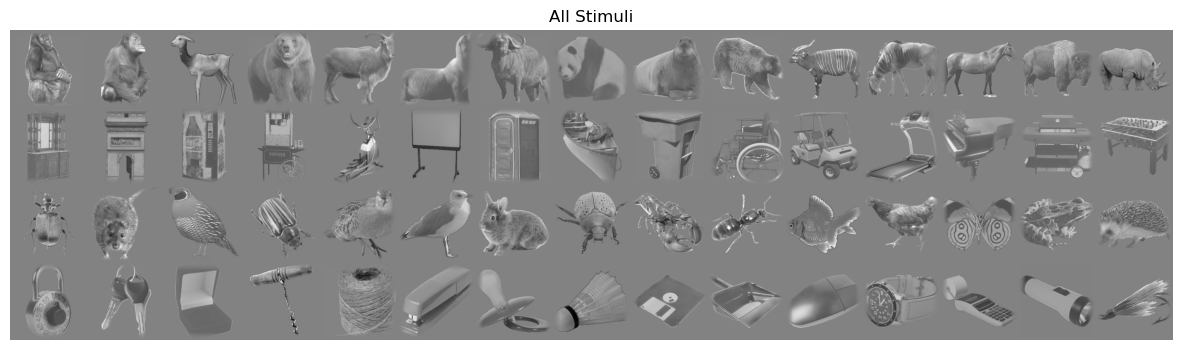

In [5]:
stim_dir = '../data/stimuli/'
display_stim(stim_dir)

In [6]:
# Stimulus IDs typically in the third column of epochs.events
stim_ids = epochs.events[:, 2]
print("Example of stimulus IDs (first 10):", stim_ids[:20])

Example of stimulus IDs (first 10): [12 48 51 36 44 52  1 34  5  4 40 22 37 47 29 30 11 27 25 56]


In [7]:
# Define the stimulus IDs for animate and inanimate categories
animate_ids = list(range(1, 16)) + list(range(31, 46))
inanimate_ids = list(range(16, 31)) + list(range(46, 61))

# Create binary labels: 1 for animate, 0 for inanimate
labels = np.array([1 if event_id in animate_ids else 0 for event_id in epochs.events[:, 2]])

print(f"Total epochs: {len(labels)}")
print(f"Number of trials labeled 'animate' (1): {(labels == 1).sum()}")
print(f"Number of trials labeled 'inanimate' (0): {(labels == 0).sum()}")


Total epochs: 960
Number of trials labeled 'animate' (1): 480
Number of trials labeled 'inanimate' (0): 480


## Category decoding (animate vs. inanimate)


We'll use:
- **`SlidingEstimator`** from MNE, which iterates over the time axis.
- A **`Pipeline`** consisting of `StandardScaler` \(\rightarrow\) `LogisticRegression`.
- **`cross_val_multiscore`** for cross-validation:
  - Input is **3D** (\(n\_epochs \times n\_channels \times n\_times\)).
  - Output is \((\text{n\_splits}, \text{n\_times})\).

We'll then compute the **mean accuracy** across folds at each time point and plot the decoding performance across time.

In [14]:
# GroupKFold with 5 splits
gkf = GroupKFold(n_splits=n_splits)

# Build the pipeline
# We include a StandardScaler to normalize features, then a logistic regression.
clf_category = SlidingEstimator(
    Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(solver='liblinear', random_state=42))
    ]),
    scoring='accuracy',
    n_jobs=4,  # Adjust n_jobs as needed for parallel processing,
    verbose=True,
)

# Cross-validate and compute scores
# cross_val_multiscore outputs an array of shape (n_splits, n_times)
scores_category = cross_val_multiscore(
    estimator=clf_category,
    X=X,
    y=labels,
    cv=gkf,
    groups=stim_ids  # ensures each stimulus is either in train OR test
)

# Average accuracy across splits at each time point
mean_scores_category = scores_category.mean(axis=0)



  0%|          | Fitting SlidingEstimator : 0/1201 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/1201 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/1201 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/1201 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/1201 [00:00<?,       ?it/s]

Scores shape (n_splits, n_times): (5, 1201)
Mean score across all time points: 0.512


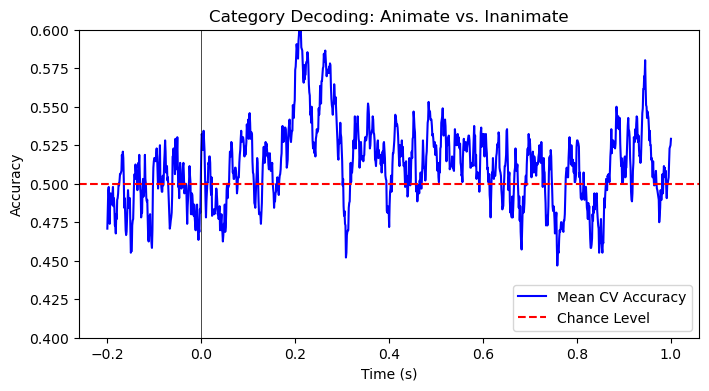

In [15]:
# Average across folds at each time point
mean_scores_category = scores_category.mean(axis=0)

print(f"Scores shape (n_splits, n_times): {scores_category.shape}")
print(f"Mean score across all time points: {mean_scores_category.mean():.3f}")

# Plot
plt.figure(figsize=(8, 4))
plt.plot(times, mean_scores_category, label='Mean CV Accuracy', color='b')
plt.axhline(0.5, color='r', linestyle='--', label='Chance Level')
plt.xlabel('Time (s)')
plt.ylabel('Accuracy')
plt.title('Category Decoding: Animate vs. Inanimate')
plt.legend()
plt.axvline(0, color='k', linestyle='-', linewidth=0.5)
plt.ylim([0.4, 0.6])
plt.show()

## Pairwise Stimulus Decoding (Practice)

Try to Decode . You can loop over multiple pairs if needed.


In [9]:
from itertools import combinations

# Stimulus IDs you're interested in decoding (e.g., 1 to 60)
all_stim_ids = list(set(stim_ids))

# Generate all unique pairs of stimuli for pairwise decoding
stim_pairs = list(combinations(all_stim_ids, 2))
print(stim_pairs)

[(np.int32(1), np.int32(2)), (np.int32(1), np.int32(3)), (np.int32(1), np.int32(4)), (np.int32(1), np.int32(5)), (np.int32(1), np.int32(6)), (np.int32(1), np.int32(7)), (np.int32(1), np.int32(8)), (np.int32(1), np.int32(9)), (np.int32(1), np.int32(10)), (np.int32(1), np.int32(11)), (np.int32(1), np.int32(12)), (np.int32(1), np.int32(13)), (np.int32(1), np.int32(14)), (np.int32(1), np.int32(15)), (np.int32(1), np.int32(16)), (np.int32(1), np.int32(17)), (np.int32(1), np.int32(18)), (np.int32(1), np.int32(19)), (np.int32(1), np.int32(20)), (np.int32(1), np.int32(21)), (np.int32(1), np.int32(22)), (np.int32(1), np.int32(23)), (np.int32(1), np.int32(24)), (np.int32(1), np.int32(25)), (np.int32(1), np.int32(26)), (np.int32(1), np.int32(27)), (np.int32(1), np.int32(28)), (np.int32(1), np.int32(29)), (np.int32(1), np.int32(30)), (np.int32(1), np.int32(31)), (np.int32(1), np.int32(32)), (np.int32(1), np.int32(33)), (np.int32(1), np.int32(34)), (np.int32(1), np.int32(35)), (np.int32(1), np.int3

In [10]:
clf_pair = SlidingEstimator(
    Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(solver='liblinear', random_state=42))
    ]),
    scoring='accuracy',
    n_jobs=1  # Adjust n_jobs as needed for parallel processing
)

# Placeholder to store results
pairwise_results = {}

# Loop over all pairs
for (stim1, stim2) in stim_pairs:

     # Find indices where the stimulus ID matches either of the pair


     # Extract data for the current pair

     # Apply Stratified K-Fold with 5 splits

     # Compute cross-validated scores

    # # Compute average accuracy
    mean_score = scores.mean(0)
    
    # Store results
    pairwise_results[(stim1, stim2)] = mean_score
